In [9]:
#2022-10-24 11:25:36 
from datetime import datetime
time = datetime.now().strftime("%Y_%m_%d")

import pandas as pd 
import numpy as np 
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from comut import comut
from comut import fileparsers

import palettable
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "arial" # if you don't have arial it will fall back to Deja Vu

In [41]:
a,b,c,d,e,f,g,h,i = [plt.cm.winter, plt.cm.cool, plt.cm.spring, plt.cm.copper, plt.cm.bone, plt.cm.gist_heat, plt.cm.pink, plt.cm.summer, plt.cm.autumn]
tumor_color = {'Germ Cell Tumor':a(.6),'Hepatoblastoma':b(.6), 
               'Osteosarcoma':f(.6),'Clear Cell Sarcoma':f(.8), 'Other Sarcoma':f(.3),
               'Wilms Tumor':h(.6), 'Neuroblastoma':h(.3),  'Other Tumor':e(.6)}

cancer_ranking_all2 = [ 'Ovarian tumor', 'Wilms Tumor', 'Ewing Sarcoma', 'Mesothelioma', 'Clear Cell Sarcoma', 'Hepatoblastoma', 'Neuroblastoma',
                        'Germ Cell Tumor', 'Pleomorphic Sarcoma', 'Adrenal cortical carcinoma', 'Osteosarcoma', 'ERMS', 'Glioblastoma']
color_ranking_palette2 = ['darkred',h(.6), 'red', 'gold', f(.3), b(.6), h(.2),a(.6), 'firebrick', 'hotpink', f(.6), f(.7), 'darkviolet']
color_dict2 = dict(zip(cancer_ranking_all2, color_ranking_palette2))

paired_id =  ['1792', '2035','1922','529','1754','54','1907', '498','1739','585','1959','1957',
                       '655','1763','1823','2050','668','2264','1932','560','1753','1826','1795','1979','1913']

### load data

In [6]:
mut = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/3.somatic_mutations/Final.somatic_mutations.maf')
purity = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/Final_purity_ploidy.seqz_pureCN.20220701.txt')
cn = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/gistic/all_thresholded.by_genes.txt')
cn.columns = cn.columns.str.replace('_WGS','',regex = True)
cn['Gene Symbol'] = cn['Gene Symbol'].str.split('|').str[0]
cn = cn.drop(['Locus ID', 'Cytoband'], axis = 1).groupby('Gene Symbol').mean().reset_index()

### comut of 4 cancer type

In [7]:
ct_select = ['Wilms Tumor',  'Hepatoblastoma','Germ Cell Tumor', 'Osteosarcoma', ]

mut_genes = ['CTNNB1','MUC16','TP53','CASKIN1','PTEN','PTK2','SYNE2']
mut_genes.reverse()

cn_genes = ['MYC','BRAF','SETDB1','CCNE1','KDM2B','TP53','CTNNB1','PTEN','SETD2','CDKN2A']
cn_genes.reverse()

In [10]:
#MUT TYPE
pt = mut[mut['Datatype'] == 'PT']
pdx = mut[mut['Datatype'] == 'PDX']

k = []
for i in list(pt.index):
    if pt.loc[i]['Tumor group2'] in ct_select:
        k.append(i)
pt = pt.T[k].T

k = []
for i in list(pdx.index):
    if pdx.loc[i]['Tumor group2'] in ct_select:
        k.append(i)
pdx = pdx.T[k].T

# Use a helper function to parse the maf. This requires a Tumor_Sample_Barcode, Hugo_Symbol, and Variant_Classification column. It will rename variant types to be more visually appealing (eg Missense_Mutation -> Missense). Only certain coding variants are shown.
pt = fileparsers.parse_maf(pt)
pdx = fileparsers.parse_maf(pdx)


#####ADD CTNNB1 large in-frame
pt.loc[len(pt.index)] = ['498_PT', 'CTNNB1', 'Large in frame del'] 
pdx.loc[len(pdx.index)] = ['498_PDX', 'CTNNB1', 'Large in frame del'] 
pdx.loc[len(pdx.index)] = ['891173_PDX', 'CTNNB1', 'Large in frame del'] 
pdx.loc[len(pdx.index)] = ['891760_PDX', 'CTNNB1', 'Large in frame del'] 


In [14]:
#continuous var
#ploidy
dt = purity[['PatientID', 'PDX_Ploidy','PT_Ploidy']].set_index('PatientID')
dt = pd.DataFrame(dt.stack()).reset_index() 
dt.columns = ['sample', 'category', 'value']
dt['sample'] =dt['sample'] + '_' + dt['category'].str.split('_').str[0]
dt['category'] = dt['category'].str.split('_').str[1]
plo = dt
#purity
dt = purity[['PatientID', 'PDX_Purity','PT_Purity']].set_index('PatientID')
dt = pd.DataFrame(dt.stack()).reset_index() 
dt.columns = ['sample', 'category', 'value']
dt['sample'] =dt['sample'] + '_' + dt['category'].str.split('_').str[0]
dt['category'] = dt['category'].str.split('_').str[1]
pur = dt
#mut
dt = mut.groupby(['PatientID','Datatype']).first()[['Tumor group2']].reset_index()
dt.columns = ['sample', 'category', 'value']
dt['sample'] =dt['sample'] + '_' + dt['category']
dt['category'] = ['Tumor type'] * len(dt)
dm = dt
ct = dt
# CNV
dt = cn.set_index('Gene Symbol').T[cn_genes].reset_index().melt(id_vars = ['index'])
dt.columns = ['sample','category','value']
dt.value = dt.value.astype(int).astype(str)
cn_sel = dt

In [17]:
dpi = 300 # change the output resolution
extension = '.pdf' # extension for saving - can otherwise be .pdf, .png, .jpg, etc

# mapping of mutation type to color. Only these mutation types are shown. Can be any valid matplotlib color, e.g. 'blue', #ffa500, or (1,1,1).
vivid_10 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
mut_mapping = {'Missense': vivid_10[6], 'Nonsense': vivid_10[3], 'In frame indel': 'lavender', 
               'Frameshift indel': vivid_10[4], 'Splice site': vivid_10[9], 'Large in frame del': 'plum',
              #'LOH': {'facecolor':'none', 'edgecolor':'black', 'linewidth':1}
              }
tropic_5 = palettable.cartocolors.diverging.TealRose_5.mpl_colors
cn_mapping = {'2': tropic_5[4], '1': tropic_5[3], '0': 'white',
               '-2': tropic_5[0], '-1': tropic_5[1], 
              }
purp_7 = palettable.cartocolors.sequential.Purp_7.mpl_colormap
mint_7 = palettable.cartocolors.sequential.Mint_7.mpl_colormap
burgyl_7 = palettable.cartocolors.sequential.BurgYl_7.mpl_colormap

tumor_type_mapping = dict((i, tumor_color[i]) for i in ct_select)

In [20]:
input_data = pdx


k = mut.set_index('ID')
k.index = k.index.str.replace('_WES', '', regex = True)
sample_order = k.T[list(set(input_data['sample']))].T.reset_index().groupby(['Tumor group2','ID']).count().sort_values('Hugo_Symbol', ascending = False).T[ct_select].T.reset_index().ID.to_list()
# generate comut
example_comut1 = comut.CoMut()
example_comut1.samples = sample_order

# add data to the CoMut object
example_comut1.add_categorical_data(cn_sel.set_index('sample').T[list(set(input_data['sample']))].T.reset_index(), name = 'Copy number', category_order = cn_genes, mapping = cn_mapping, tick_style = 'italic')

example_comut1.add_categorical_data(input_data, name = 'Mutation type', category_order = mut_genes, mapping = mut_mapping, tick_style = 'italic')
example_comut1.add_continuous_data(pur.set_index('sample').T[list(set(input_data['sample']))].T.reset_index(), name = 'Purity',  mapping = 'Reds', value_range = (0, 1))
example_comut1.add_continuous_data(plo.set_index('sample').T[list(set(input_data['sample']))].T.reset_index(), name = 'Ploidy',  mapping = 'coolwarm', value_range = (0,4))
example_comut1.add_categorical_data(ct.set_index('sample').T[list(set(input_data['sample']))].T.reset_index(), name='Tumor type', mapping = tumor_type_mapping)


In [21]:
input_data = pt

k = mut.set_index('ID')
k.index = k.index.str.replace('_WES', '', regex = True)
sample_order = k.T[list(set(input_data['sample']))].T.reset_index().groupby(['Tumor group2','ID']).count().sort_values('Hugo_Symbol', ascending = False).T[ct_select].T.reset_index().ID.to_list()

# generate comut
example_comut2 = comut.CoMut()
example_comut2.samples = sample_order

# add data to the CoMut object
example_comut2.add_categorical_data(cn_sel.set_index('sample').T[list(set(input_data['sample']))].T.reset_index(), name = 'Copy number', category_order = cn_genes, mapping = cn_mapping, tick_style = 'italic')

example_comut2.add_categorical_data(input_data, name = 'Mutation type', category_order = mut_genes, mapping = mut_mapping, tick_style = 'italic')
example_comut2.add_continuous_data(pur.set_index('sample').T[list(set(input_data['sample']))].T.reset_index(), name = 'Purity',  mapping = 'Reds', value_range = (0, 1))
example_comut2.add_continuous_data(plo.set_index('sample').T[list(set(input_data['sample']))].T.reset_index(), name = 'Ploidy',  mapping = 'coolwarm', value_range = (0,4))
example_comut2.add_categorical_data(ct.set_index('sample').T[list(set(input_data['sample']))].T.reset_index(), name='Tumor type', mapping = tumor_type_mapping)


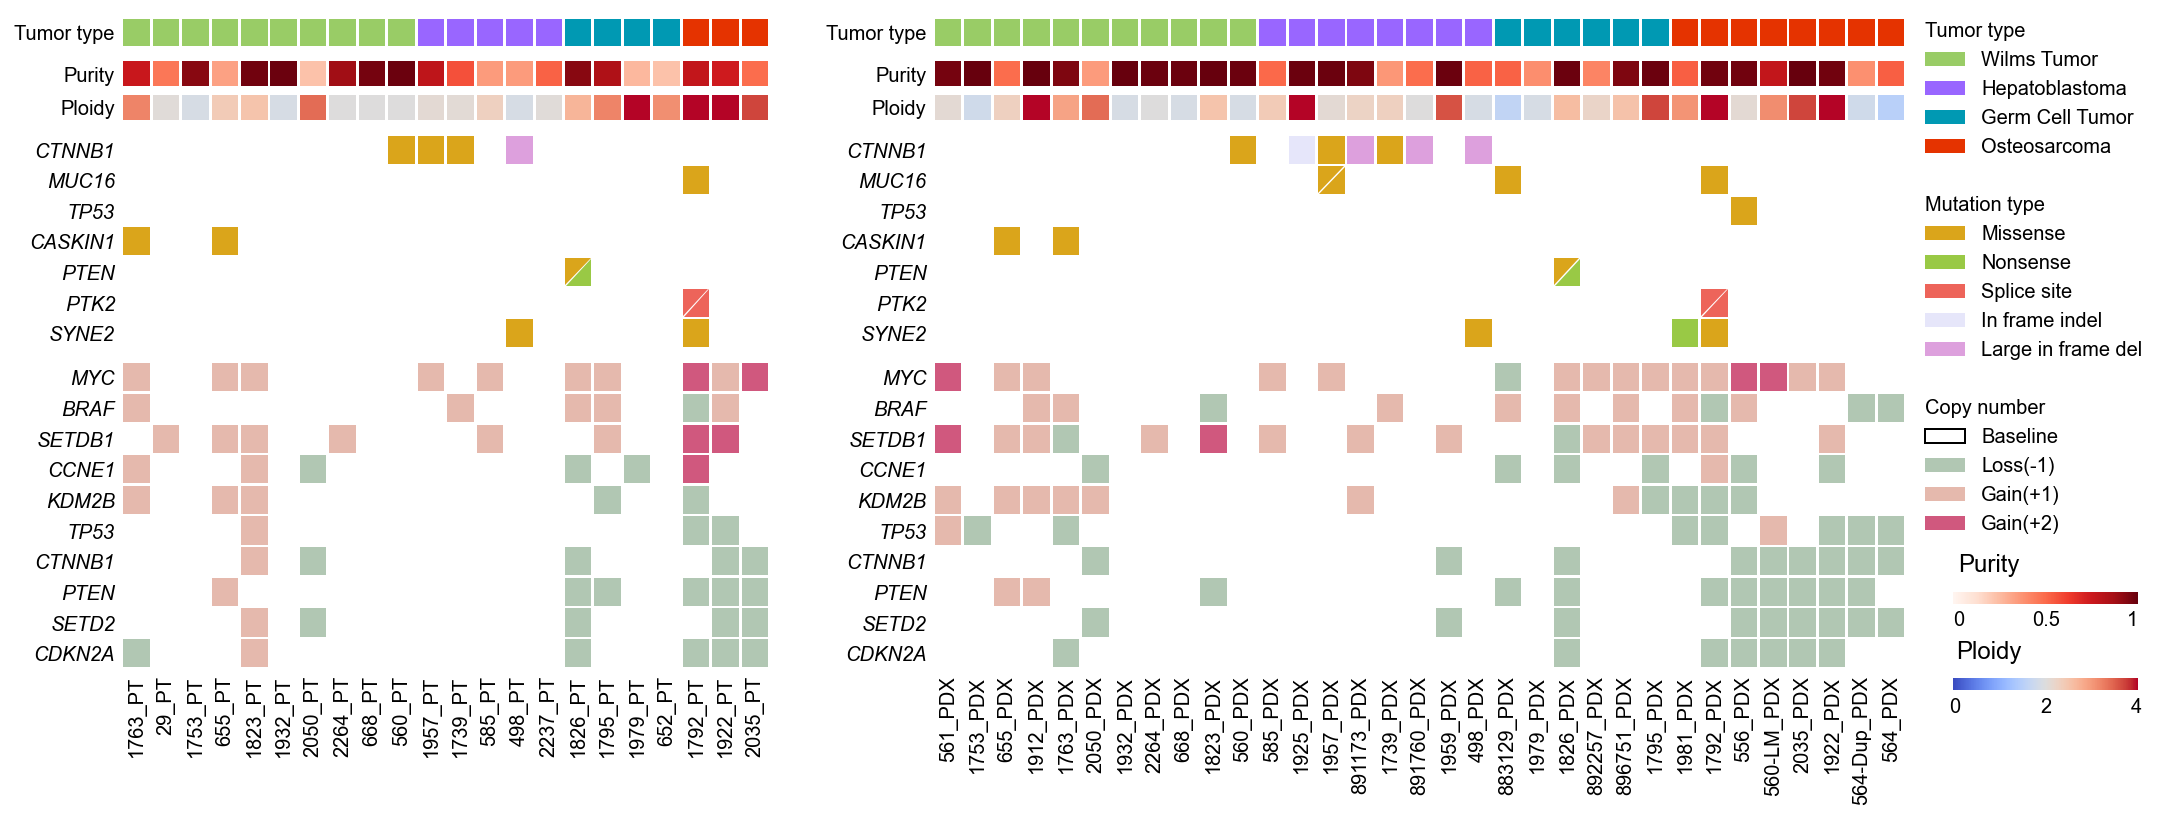

In [22]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16, 6), tight_layout=False)
gs = fig.add_gridspec(1, 2, width_ratios = [2,3], wspace=0.2)

# define structure
structure = [
             ['Copy number'],
             ['Mutation type'],
             ['Ploidy','Purity'], 
             ['Tumor type']]


# plot the comut
example_comut2.plot_comut(x_padding = 0.05, y_padding = 0.04, tri_padding = 0.03, hspace = 0.08, wspace = 0.05, structure = structure,
                           fig = fig, spec = gs[0]) 

example_comut1.plot_comut(x_padding = 0.05, y_padding = 0.04, tri_padding = 0.03, hspace = 0.08,  wspace = 0.05, structure = structure,
                           fig = fig, spec = gs[1]) 


#ignored_values = ['0']
border_white = ['0']
rename = {'0':'Baseline', '1':'Gain(+1)', '2':'Gain(+2)', '-1': 'Loss(-1)', '-2': 'Loss(-2)'}

example_comut1.add_unified_legend(bbox_to_anchor = (1, 1.4), border_white=border_white, rename = rename,# ignored_values=ignored_values,
                              ncol = 1)

##### add color bar##############
purity_ax = example_comut1.figure.add_axes([0.92, 0.2, 0.08, 0.014])
ploidy_ax = example_comut1.figure.add_axes([0.92, 0.1, 0.08, 0.014])

# purity/ploidy ranges from 0 to 1
norm1 = mpl.colors.Normalize(vmin=0, vmax=1)
norm2 = mpl.colors.Normalize(vmin=0, vmax=4)

# create the colorbar with colormap used when the continuous data was added (purp_7)
purity_colorbar = example_comut1.figure.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap='Reds'),
                                                 cax=purity_ax, orientation='horizontal')
ploidy_colorbar = example_comut1.figure.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap='coolwarm'),
                                                 cax=ploidy_ax, orientation='horizontal')


# remove tick marks and move tick labels slightly inwards. Also remove black border
purity_colorbar.ax.tick_params(size=0)
purity_colorbar.set_ticks([0.03,0.5,0.97])
purity_colorbar.set_ticklabels([0,0.5,1])
purity_colorbar.outline.set_visible(False)

ploidy_colorbar.ax.tick_params(size=0)
ploidy_colorbar.set_ticks([0.03,2,3.97])
ploidy_colorbar.set_ticklabels([0,2,4])
ploidy_colorbar.outline.set_visible(False)

# set title of colorbar to line up with other legend elements
purity_colorbar.set_label('Purity', labelpad = -38, x = 0.19, fontsize = 12)
ploidy_colorbar.set_label('Ploidy', labelpad = -38, x = 0.19, fontsize = 12)

In [1027]:
#gs.figure.savefig('/home/UTHSCSA/hef/2.Project/5.PDX/3.plot/7.comut/comut.by_cancer_type.'+time+'.pdf', bbox_inches = 'tight', dpi = 300)


### comut of 25 samples

In [23]:
mut_genes = ['CTNNB1','TP53', 'CSMD3','MUC16',  'PTEN', 'LRP2','CASKIN1','SALL3','SYNE2',  'TTN']  # top 5 cgc + top 5 non-cgc
mut_genes.reverse()

cn_genes = ['MYC','SETDB1','BRAF','CDKN2A','PTEN','CTNNB1','SETD2', 'TP53','CCND3','KDM2B']  #top 5 gain + top 5 loss
cn_genes.reverse()


In [42]:
tumor = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/3.plot/7.comut/paired_sample/tumor_type.txt')
tumor['sample'] = tumor['sample'].astype(str)
germline = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/3.plot/7.comut/paired_sample/germline.txt')
germline['sample'] = germline['sample'].astype(str)

In [43]:
#MUT
dt = fileparsers.parse_maf(mut)
dt['Datatype'] = dt['sample'].str.split('_').str[1]
dt['sample'] = dt['sample'].str.split('_').str[0]
dt = dt.drop_duplicates().set_index(['sample']).T[paired_id].T
dt['k']=[1] * len(dt)
dt = dt.reset_index().set_index(['sample','Datatype','value','category']).unstack('Datatype').fillna(0)
dt.columns = ['PDX','PT']
dt = dt.reset_index().melt(id_vars = ['sample', 'value', 'category'],  value_name = 'type')
k = []
for i in range(len(dt)):
    if dt['type'][i] == 1:
        k.append(dt['value'][i])
    elif dt['type'][i] == 0:
        k.append('Wild type')
mut_input = dt[['sample', 'category','variable']]
mut_input['value'] = k
mut_input  = mut_input.sort_values(['sample','category','variable']).reset_index().drop('index', axis = 1)
mut_input['value'] = mut_input['variable']+'-'+mut_input['value']


#####ADD CTNNB1 large in-frame
mut_input.loc[len(mut_input.index)] = ['498', 'CTNNB1', 'PDX', 'PDX-Large in frame del'] 
mut_input.loc[len(mut_input.index)] = ['498', 'CTNNB1', 'PT', 'PT-Large in frame del'] 

<ipython-input-43-e6761cbcbe56>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_input['value'] = k


In [44]:
#CNV
dt = cn.set_index('Gene Symbol').T[cn_genes].astype(int).astype(str)
dt = dt.replace('0', 'Baseline').replace('1','Gain').replace('2','Gain').replace('-1','Loss').replace('-2','Loss').reset_index().melt(id_vars = 'index')
dt['sample'] = dt['index'].str.split('_').str[0]
dt['Datatype'] = dt['index'].str.split('_').str[1]
dt = dt.sort_values('Datatype')

dt = dt.set_index('sample').T[paired_id].T.reset_index()
cn_input = dt[['sample','Gene Symbol','value','Datatype']]
cn_input.columns = ['sample','category','value','Datatype']
cn_input  = cn_input.sort_values(['sample','category','Datatype']).reset_index().drop('index', axis = 1)
cn_input['value'] = cn_input['Datatype']+'-'+cn_input['value']

In [47]:
# create comut object and add categorical and continuous data
paired_comut = comut.CoMut()
paired_comut.samples = paired_id


# CNV
tropic_5 = palettable.cartocolors.diverging.TealRose_7.mpl_colors
cn_mapping = {  'PT-Baseline': 'white', 'PDX-Baseline': 'white',
                            'PT-Gain': tropic_5[5], 'PDX-Gain': tropic_5[5], 
                            'PT-Loss': tropic_5[1],  'PDX-Loss': tropic_5[1],
             }
value_order = list(cn_mapping.keys() )[::2]  

paired_comut.add_categorical_data(cn_input, name = 'Copy number', category_order = cn_genes, mapping = cn_mapping, tick_style = 'italic',value_order = value_order, priority = None)

# Mutations
vivid_10 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
mut_mapping = {'PT-Wild type':'white', 'PDX-Wild type':'white', 
               'PT-Missense': vivid_10[6], 'PDX-Missense': vivid_10[6],    #6-3-1-4-9
               'PT-Nonsense': vivid_10[3], 'PDX-Nonsense': vivid_10[3], 
               'PT-In frame indel': 'lavender', 'PDX-In frame indel': 'lavender', 
               'PT-Frameshift indel': vivid_10[4],  'PDX-Frameshift indel': vivid_10[4], 
               'PT-Splice site': vivid_10[9],  'PDX-Splice site': vivid_10[9], 
               'PT-Large in frame del': 'plum', 'PDX-Large in frame del': 'plum', 
              # 'Absent':'lightgray',
              #'LOH': {'facecolor':'none', 'edgecolor':'black', 'linewidth':1}
              }
value_order = list(mut_mapping.keys() )[::2]  
#priority = ['Nonsense']

paired_comut.add_categorical_data(mut_input, name = 'Mutation type', category_order = mut_genes, mapping = mut_mapping, tick_style = 'italic', value_order = value_order, priority=None)


# tumor type + germline
germline_mapping = {'yes': '.4', 'no': 'lightgray'}
paired_comut.add_categorical_data(germline, name='Germline', mapping = germline_mapping)

paired_comut.add_categorical_data(tumor, name='Tumor type', mapping = color_dict2)



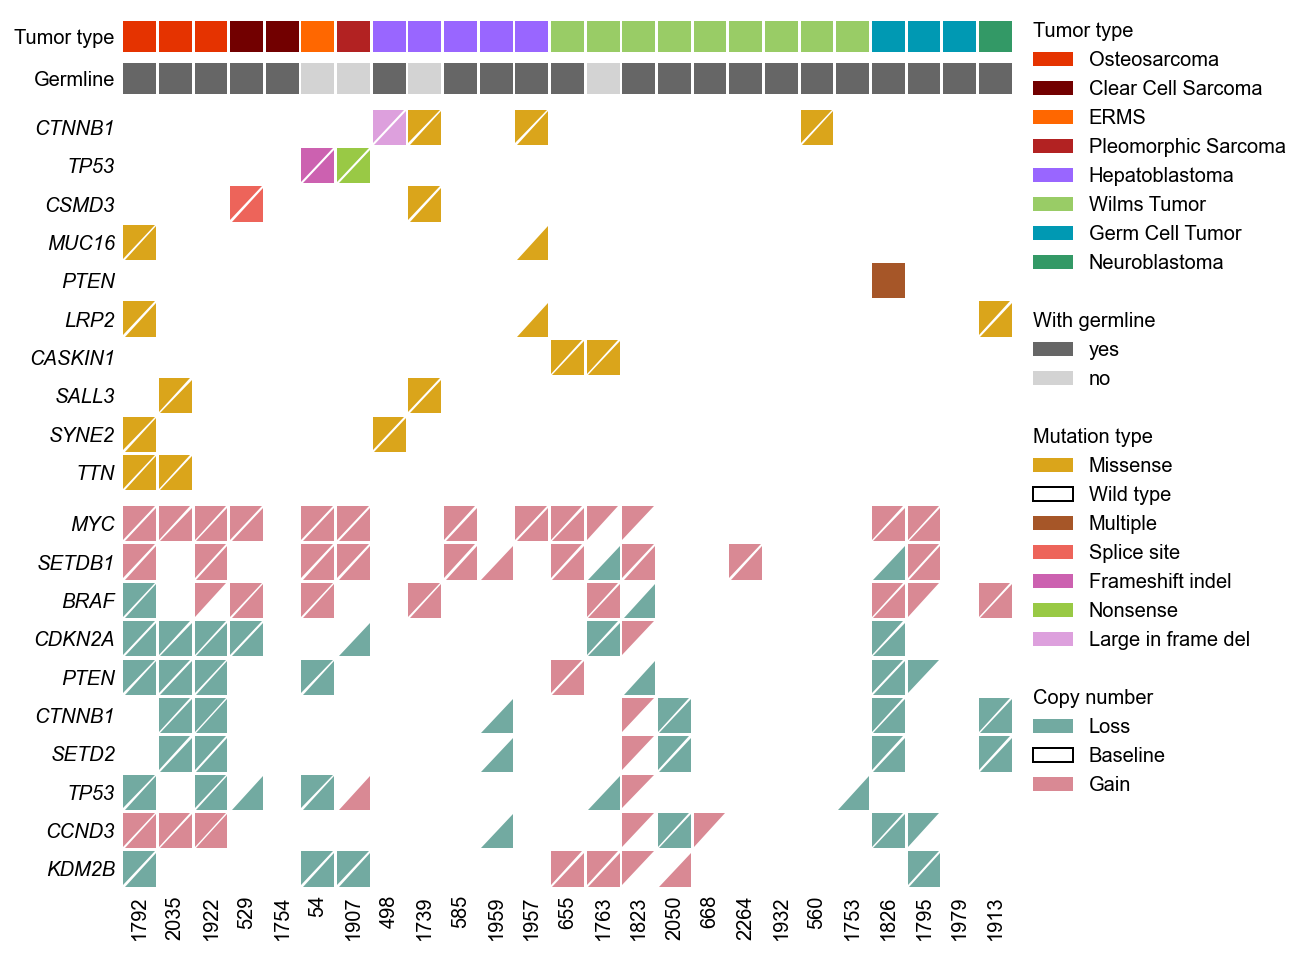

In [48]:
structure = [
             ['Copy number'],
             ['Mutation type'],
             ['Germline','Tumor type'], 
        ]
#PLOT
paired_comut.plot_comut(figsize = (8, 8), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.04, hspace = 0.04, structure= structure)

#LEGEND
ignored_values = ['similarity', 'add','Wild type'] + list(mut_mapping.keys() )[1::2] +  list(cn_mapping.keys() )[1::2] + [ 'PT-Wild type']
border_white = ['PT-Baseline', 'Absent']
rename = {'Absent': 'Wild type','Germline':'With germline', 'Similarity':None, 'PT-Baseline':'Baseline', 'PT-Gain':'Gain', 'PT-Loss':'Loss',
          'PT-Missense':'Missense', 'PT-Splice site':'Splice site', 'PT-Frameshift indel':'Frameshift indel', 'PT-Nonsense':'Nonsense', 
          'PT-Large in frame del':'Large in frame del'
         }
paired_comut.add_unified_legend(bbox_to_anchor = (1, 1.4), border_white=border_white, ignored_values=ignored_values,  rename = rename,#
                              ncol = 1)



In [1071]:
#paired_comut.figure.savefig('/home/UTHSCSA/hef/2.Project/5.PDX/3.plot/7.comut/comut.PT_PDX_paired.'+time+'.pdf', bbox_inches = 'tight', dpi = 300)
